<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/lindevanbeers/Lab-3/linde-report-lab-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3: Iterative Methods**
**Linde van Beers**

# **Abstract**

This report contains implementations of Jacobi iteration, Gauss-Seidel Iteration and Newton's method for both scalar and vector nonlinear equations. All methods work for the tests they were submitted to. 

#**About the code**

In [55]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Author: Linde van Beers, 2020

# Based on a template:
# Copyright (C) 2019 Johan Hoffman (jhoffman@kth.se)


# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np
import math
import scipy as sp

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D
from scipy import misc

# method needed later
def direct_solve(A,b):
  n = A.shape[1]
  m = A.shape[0]
  x = np.zeros(n)

  # Put A and b in such a format that A is upper triangular
  if A[0,0]==0:
    for i in range(m):
      if A[i,0] != 0:
        A[0,:] = A[0,:] + A[i,:]/A[i,0]
        b[0] = b[0] + b[i]/A[i,0]
        break
  for i in range(m-1):
    for j in range(i+1,n):
      c = A[j,i]/A[i,i]
      A[j,:] = A[j,:] - c*A[i,:]
      b[j] = b[j] - c*b[i]

  # Use backward substitution to solve
  x[n-1] = b[n-1]/A[n-1,n-1]
  for i in range(n-2,-1,-1):
    sum = 0
    for j in range(i+1, n):
      sum = sum +A[i,j]*x[j]
    x[i] = (b[i]-sum)/A[i,i]
  
  return x

# **Introduction**

In this report I have tested and implemented four methods as described in part four of the lecture notes. These methods are Jacobi iteration, Gauss-Seidel Iteration and Newton's method for both scalar and vector nonlinear equations. 




# **Methods**

### Jacobi Iteration for Ax=b

This algorithm takes as input nxn matrix A, and vector b of length n, and a floating number tol.

The output is an approximation of vector x such that Ax = b. The accuracy is such that $||b-Ax|| \leq tol$. 

This algorithm uses the formula 

$x_i^{(k+1)} = a_{ii}^{-1} \left(b_i - \sum\limits_{j≠i} a_{ij}x_j^{(k)}\right)$

to calculate the iterations of $x$.

In [0]:
def jacobi_iter(A, b, tol, test):
  # Initialization
  n = A.shape[0]
  D = np.multiply(A,np.eye(n))
  A2 = A - D
  Dinvm = np.multiply(1/A,np.eye(n))
  Dinv = np.zeros([n,]) # Put values of D inverse in array for faster computation
  for i in range(n):
    Dinv[i] = Dinvm[i,i]
  x = np.zeros([n,])
  k = 0
  xnew = x.copy()
  # Jacobi iteration algorithm
  r = b - np.matmul(A,x)
  rs = np.array([np.linalg.norm(r)])
  while np.linalg.norm(r) > tol:
    xnew = np.array(np.multiply(Dinv, b-np.matmul(A2,x)))[0] # implementation of the function
    x = xnew.copy()
    r = b - np.matmul(A,x)
    rs = np.append(rs, np.linalg.norm(r))
    k += 1  
  # Covergence visualisation
  fig = plt.figure()
  rPlt = fig.add_subplot(111)
  rPlt.plot(rs, np.array(range(k+1)))
  rPlt.set_xlabel("iterations")
  rPlt.set_ylabel("||r||")
  plt.title("Convergence of ||r||, where r = b-Ax, over iterations\n for test %i" % test)
  return x

def converge_criterion_J(A):
  n = A.shape[0]
  I = np.eye(n)
  Dinv = np.multiply(1/A,I)
  M = I - np.matmul(Dinv,A)
  eigvals = np.linalg.eigvals(M)
  max = 0
  for i in range(len(eigvals)):
    if eigvals[i] > max:
      max = eigvals[i]
  if max < 1:
    return True
  else:
    return False

### Gauss-Seidel Iteration for Ax=b

This algorithm takes as input nxn matrix A, and vector b of length n, and a floating number tol.

The output is an approximation of vector x such that Ax = b. The accuracy is such that $||b-Ax|| \leq tol$. 

This algorithm uses the formula 

$x_i^{(k+1)} = a_{ii}^{-1} \left(b_i - \sum\limits_{j<i} a_{ij}x_j^{(k)}- \sum\limits_{j>i} a_{ij}x_j^{(k)}\right)$

to calculate the iterations of $x$.

In [0]:
def forward_sub(L,b):
  n = L.shape[1]
  x = np.zeros(n)
  # Use backward substitution to solve
  x[0] = b[0]/L[0,0]
  for i in range(1,n):
    sum = 0
    for j in range(0, i):
      sum = sum +L[i,j]*x[j]
    x[i] = (b[i]-sum)/L[i,i]  
  return x

def GS_iter(A, b, tol, test):
  # Initialization
  n = A.shape[0]
  x = np.zeros([n,])
  xnew = x.copy()
  k = 0

  # Calculate iteration matrix
  L = A.copy()
  for i in range(n):
    for j in range(i,n):
      L[i,j] = 0
  U = A.copy()
  for i in range(n):
    for j in range(0,i+1):
      U[i,j] = 0
  Dinvm = np.multiply(1/A,np.eye(n))
  Dinv = np.zeros([n,]) # Put values of D inverse in array for faster computation
  for i in range(n):
    Dinv[i] = Dinvm[i,i]

  # Gauss-Seidel iteration algorithm
  r = b - np.matmul(A,x)
  rs = np.array([np.linalg.norm(r)])
  while np.linalg.norm(r) > tol:
    xnew = np.array(np.multiply(Dinv, b-np.matmul(L,x)-np.matmul(U,x)))[0] # implementation of the function
    x = xnew.copy()
    r = b - np.matmul(A,x)
    rs = np.append(rs, np.linalg.norm(r))
    k += 1
  # Covergence visualisation
  fig = plt.figure()
  rPlt = fig.add_subplot(111)
  rPlt.plot(rs, np.array(range(k+1)))
  rPlt.set_xlabel("iterations")
  rPlt.set_ylabel("||r||")
  plt.title("Convergence of ||r||, where r = b-Ax, over iterations\n for test %i" % test)
  return x

def converge_criterion_GS(A):
  n = A.shape[0]
  I = np.eye(n)
  Dinv = np.multiply(1/A,I)
  L = A.copy()
  for i in range(n):
    for j in range(i+1,n):
      L[i,j] = 0
  Linv = np.matrix(forward_sub(L, np.array(I[:,0]))).T
  for i in range(1,n):
    Linv = np.append(Linv, np.matrix(forward_sub(L, np.array(I[:,i]))).T, axis = 1) 
  M = I - np.matmul(Linv,A)
  eigvals = np.linalg.eigvals(M)
  max = 0
  for i in range(len(eigvals)):
    if eigvals[i] > max:
      max = eigvals[i]
  if max < 1:
    return True
  else:
    return False

### Newton's method for scalar nonlinear equation f(x)=*0*

This algorithm takes as input a function, an interval, and the tolerance for the solution. The interval serves as limits for the initial guess, but mainly are used for the visualisation of the function. 

The algorithm implements newton's methd for solving nonlinear scalar equations $f(x) = 0$. The iteration formula is: 

$x^{(k+1)} = x^{(k)}-\frac{f\left(x^{(k)}\right)}{f'\left(x^{(k)}\right)}$

In [0]:
# return x such that f(x) = 0
def newton(f, x, interval, tol, test):
  k = 0
  x = np.random.random()*(interval[1]-interval[0])+interval[0]
  xs = np.array(x)
  e = np.array(abs(f(x)))
  # fixed point function
  def g(xk):
    df = sp.misc.derivative(f,xk)   
    if df == 0: # to prevent dividing by 0 we take default value -1 if df = 0 (corresponds to alpha = 1)
      df = -1
    return xk-f(xk)/df

  while abs(f(x)) > tol:
    x = g(x)
    xs = np.append(xs, x)
    e = np.append(e, abs(f(x)))
    k+=1

  # Plot the process
  fig = plt.figure()
  fun = fig.add_subplot(133)
  con = fig.add_subplot(221)
  err = fig.add_subplot(223)
  inp=np.array(np.linspace(interval[0], interval[1], 20))
  y = np.zeros([20,])
  for i in range(20):
    y[i] = f(inp[i])
  con.plot(np.array(range(k+1)), xs)
  err.plot(np.array(range(k+1)), e)
  fun.plot(inp,y)
  err.set_xlabel("iterations")
  con.set_xlabel("iterations")
  err.set_ylabel("|f(x)|")
  con.set_ylabel("x")
  fun.set_xlabel("x")
  fun.set_ylabel("f(x)")
  fun.set_xlim(interval[0], interval[1])
  con.title.set_text("convergence of x and |f(x)|\n for test %i" % test)
  fun.title.set_text("f(x)")
  return x

### Newtons method for vector nonlinear equation *f(x) = 0*

The following algorithm uses newtons method to solve nonlinear equation systems. I have choses to implement a function that calculates the Jacobian matrix using finite differences. 

To solve the linear system in each iteration I used my direct solve method from the previous lab, which can be found at the top of the report in the [environment setup](https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/lindevanbeers/Lab-3/linde-report-lab-3.ipynb#scrollTo=Xw7VlErAX7NS).

In [0]:
def newton_sys(f, x0, input_shape, output_shape, tol, test):
  x = x0
  k = 0
  xnorms = np.array(np.linalg.norm(f(x)))

  def jacobian(fun, xk):
    eps = 1e-10
    jac = np.zeros([output_shape, input_shape])
    for i in range(input_shape):
      x1 = xk.copy()
      x2 = xk.copy()
      x1[i] += eps
      x2[i] -= eps
      f1 = fun(x1)
      f2 = fun(x2)
      jac[:,i] = (f1-f2) / (2*eps)
    return jac

  while np.linalg.norm(f(x)) > tol:
    Df = jacobian(f,x)
    dx = direct_solve(Df, -f(x))
    x = x + dx
    k+=1
    xnorms = np.append(xnorms, np.linalg.norm(f(x)))

  fig = plt.figure()
  rPlt = fig.add_subplot(111)
  rPlt.plot(np.array(range(k+1)), xnorms)
  rPlt.set_xlabel("iterations")
  rPlt.set_ylabel("||f(x)||")
  plt.title("Convergence of ||f(x)|| over iterations\nfor test %i" % test)

  return x


# **Results**

### Jacobi Iteration for *Ax=b*

I have done 3 tests: 1 and 2 both show the covergence of the residual, the second also has an exact solution, for which I calculated the distance between the solution of my algorithm and the exact solution. 

The 3rd test is one that does not meet the covergence criterion, which the written method detects, and therefore it will not attempt to calculate an answer. 

Test 1
A: [[20  1 -2]
 [ 3 20 -1]
 [ 2 -3 20]]
b: [ 17 -18  25]
x: [ 0.9999995  -0.99999713  0.99999175]
Ax: [[ 17.00000938 -17.99993575  24.99982537]]
||b-Ax|| = 0.0001863057802412386

Test 2
A: [[20  1 -2]
 [ 3 20 -1]
 [ 2 -3 20]]
y: [ 17 -18  25]
b: [ 272 -334  588]
x: [ 16.99997933 -18.00001014  25.0000087 ]
Ax: [[ 271.99955896 -334.00027347  588.00016306]]
||b-Ax|| = 0.00054395958570255
||y-x|| = 2.4615331222363075e-05

Test 3
A: [[1 2 3]
 [4 5 6]
 [7 8 9]]
b: [1 2 3]
Convergence criterion was not met




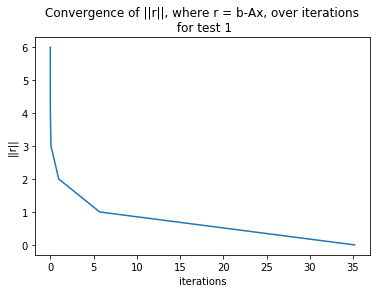

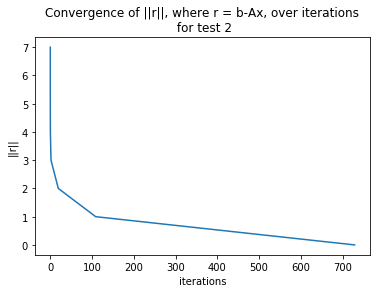

In [60]:
tol = 0.001

print("Test 1")
A = np.matrix([[20,1,-2],[3,20,-1],[2,-3,20]])
b = np.array([17,-18,25])
print("A:", A)
print("b:", b)
if converge_criterion_J(A):
  x = jacobi_iter(A,b,tol,1)
  print("x:", x)
  print("Ax:",np.matmul(A,x))
  print("||b-Ax|| =", np.linalg.norm(b-np.matmul(A,x)))
else:
  print("Convergence criterion was not met")

print("\nTest 2")
A = np.matrix([[20,1,-2],[3,20,-1],[2,-3,20]])
y = np.array([17,-18,25])
b = np.array(np.matmul(A,y))[0]
print("A:", A)
print("y:", y)
print("b:", b)
if converge_criterion_J(A):
  x = jacobi_iter(A,b,tol,2)
  print("x:", x)
  print("Ax:",np.matmul(A,x))
  print("||b-Ax|| =", np.linalg.norm(b-np.matmul(A,x)))
  print("||y-x|| =", np.linalg.norm(y-x))
else:
  print("Convergence criterion was not met")

print("\nTest 3")
A = np.matrix([[1,2,3],[4,5,6],[7,8,9]])
b = np.array([1,2,3])
#b = np.array(np.matmul(A,y))[0]
print("A:", A)
print("b:", b)
if converge_criterion_J(A):
  x = jacobi_iter(A,b,tol,3)
  print("x:", x)
  print("Ax:",np.matmul(A,x))
else:
  print("Convergence criterion was not met")
print("\n")

### Gauss-Seidel Iteration for *Ax=b*

I carried out the same 3 test as for the Jacobi iteration:

1 and 2 both show the covergence of the residual, the second also has an exact solution, for which I calculated the distance between the solution of my algorithm and the exact solution.

The 3rd test is one that does not meet the covergence criterion, which the written method detects, and therefore it will not attempt to calculate an answer.

Test 1
A: [[12  3 -5]
 [ 1  5  3]
 [ 3  7 13]]
b: [ 1 28 76]
x: [0.99996753 3.00006482 4.00002598]
Ax: [[ 0.99967489 28.00036959 76.00069412]]
||b-Ax|| = 0.0008509435401714811

Test 2
A: [[20  1 -2]
 [ 3 20 -1]
 [ 2 -3 20]]
y: [ 17 -18  25]
b: [ 272 -334  588]
x: [ 16.99997933 -18.00001014  25.0000087 ]
Ax: [[ 271.99955896 -334.00027347  588.00016306]]
||b-Ax|| = 0.00054395958570255
||y-x|| = 2.4615331222363075e-05

Test 3
A: [[1 2 3]
 [4 5 6]
 [7 8 9]]
b: [1 2 3]
Convergence criterion was not met




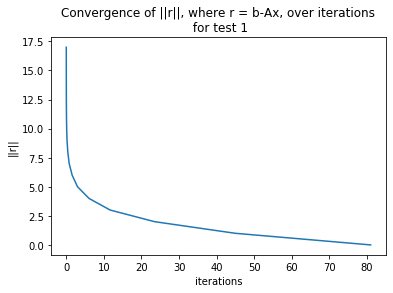

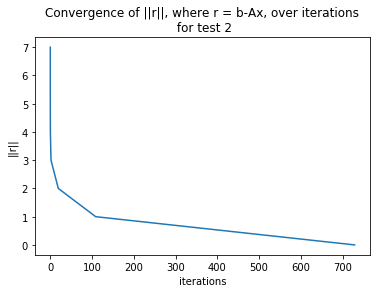

In [61]:
tol = 0.001

print("Test 1")
A = np.matrix([[12,3,-5],[1,5,3],[3,7,13]])
b = np.array([1,28,76])
# A = np.matrix([[20,1,-2],[3,20,-1],[2,-3,20]])
# b = np.array([17,-18,25])
print("A:", A)
print("b:", b)
if converge_criterion_GS(A):
  x = GS_iter(A,b,tol,1)
  print("x:", x)
  print("Ax:",np.matmul(A,x))
  print("||b-Ax|| =", np.linalg.norm(b-np.matmul(A,x)))
else:
  print("Convergence criterion was not met")

print("\nTest 2")
A = np.matrix([[20,1,-2],[3,20,-1],[2,-3,20]])
y = np.array([17,-18,25])
b = np.array(np.matmul(A,y))[0]
print("A:", A)
print("y:", y)
print("b:", b)
if converge_criterion_GS(A):
  x = GS_iter(A,b,tol,2)
  print("x:", x)
  print("Ax:",np.matmul(A,x))
  print("||b-Ax|| =", np.linalg.norm(b-np.matmul(A,x)))
  print("||y-x|| =", np.linalg.norm(y-x))
else:
  print("Convergence criterion was not met")

print("\nTest 3")
A = np.matrix([[1,2,3],[4,5,6],[7,8,9]])
b = np.array([1,2,3])
#b = np.array(np.matmul(A,y))[0]
print("A:", A)
print("b:", b)
if converge_criterion_GS(A):
  x = GS_iter(A,b,tol,3)
  print("x:", x)
  print("Ax:",np.matmul(A,x))
else:
  print("Convergence criterion was not met")
print("\n")

### Newton's method for scalar nonlinear equation *f(x)=0*


Test 1
f(x) = cos(x)
Find x such that f(x) = 0:
1.5713982548199683

Test 2
f(x) = x^3 - 2
Find x such that f(x) = 0:
1.2598702331502585
known solution y = 1.2599210498948732
|y-x| = 5.0816744614712306e-05

Test 3
f(x) = x^2 - (2x)^2 * sin(x)
Find x such that f(x) = 0:
-3.3942778317801783


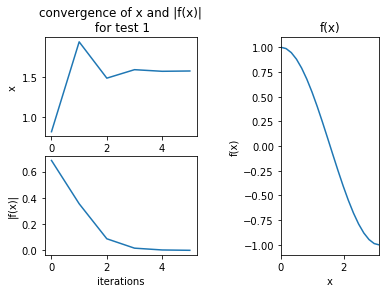

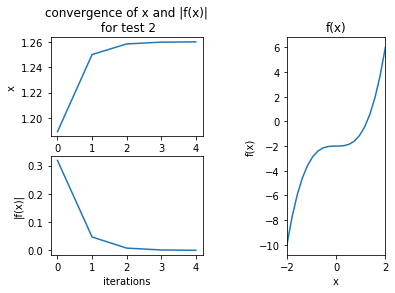

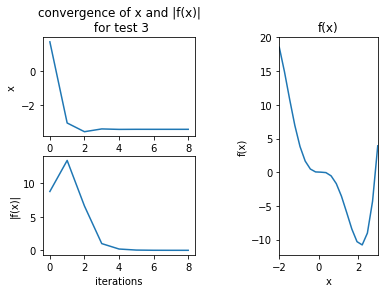

In [62]:
def function1(x):
  return math.cos(x)

x = newton(function1 ,[0, math.pi], 0.001,1)
print("Test 1")
print("f(x) = cos(x)")
print("Find x such that f(x) = 0:")
print(x)

def function2(x):
  return pow(x, 3)-2

x = newton(function2 ,[-2, 2], 0.001, 2)
print("\nTest 2")
print("f(x) = x^3 - 2")
print("Find x such that f(x) = 0:")
print(x)
print("known solution y =", pow(2,1/3))
print("|y-x| =", abs(pow(2,1/3) - x))

def function3(x):
  return pow(x,2) - pow(2*x,2)*math.sin(x)

x = newton(function3 ,[-2, 3], 0.001, 3)
print("\nTest 3")
print("f(x) = x^2 - (2x)^2 * sin(x)")
print("Find x such that f(x) = 0:")
print(x)


### Newtons method for vector nonlinear equations *f(x) = 0*

Test 1
x: [-1.57081068e+00  1.43495274e-05]
f(x): [-1.23545265e-10  1.43497333e-05  1.77635684e-15]
||f(x)||: 1.4349733333605245e-05

Test2
known solution: y = [3 4]
x: [3. 4.]
||y-x||: 4.018316186266379e-09
f(x): [ 8.94249865e-08 -2.02880365e-07]
||f(x)||: 2.2171438992205993e-07


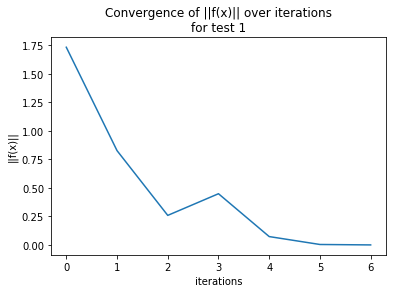

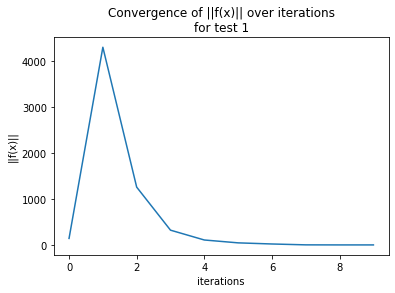

In [156]:
def function(x):
  fx = np.array(np.zeros(3))
  fx[0] = math.cos(x[0]) + math.sin(x[1])
  fx[1] = pow(math.cos(x[0]), 2) + x[1]
  fx[2] = math.sin(x[0]) + math.cos(x[1])
  return fx

print("Test 1")
x = newton_sys(function, np.array([0.,0.]), 2, 3, 0.001, 1)
print("x:", x)
print("f(x):",function(x))
print("||f(x)||:", np.linalg.norm(function(x)))



def function2(x):
  fx = np.array(np.zeros(2))
  fx[0] = 3 * pow(x[0],3) + 4 * pow(x[1],2) - 145
  fx[1] = 4 * pow(x[0],2) - pow(x[1],3) + 28
  return fx

print("\nTest2")
x = newton_sys(function2, np.array([1.,1.]),2,2,0.001,1)
print("known solution: y =", np.array([3,4]))
print("x:", x)
print("||y-x||:", np.linalg.norm(np.array([3,4])-x))
print("f(x):",function2(x))
print("||f(x)||:", np.linalg.norm(function2(x)))

# **Discussion**

All algorithms worked as they are supposed to in the end, provided they are given input they can actually manage. For example, I thought I had problems getting my newton's method for systems to work, purely because I was testing on a system where f(x) = 0 was not true for any x. 

If I had some more time I would work on simplifying my first two functions, because they could have been written much more efficiently using the iteration matrix that I already calculate when I check the convergence criterion anyway. However, my current solution is already working and I decided I'd rather spend my time working on the extra assignment. 